# Определение возраста покупателей

**Описание проекта:**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта:** построить модель, которая по фотографии определит приблизительный возраст человека. 

**Метрика качества:** MAE (mean_absolute_error).

**План:**

1. Исследовательский анализ данных.
2. Обучить модель на GPU-ускорителе.
3. Анализ результата обучения модели.

**Импорты и чтение данных**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 42
CSV_PATH = '/datasets/faces/labels.csv'
IMG_PATH = '/datasets/faces/final_files/'

In [4]:
def display_main_info(df):
    print('________________Head________________')
    display(df.head())
    print('________________Data Types Info________________')
    display(df.info())
    print('________________Shape________________')
    display(df.shape)
    print('________________Duplicates________________')
    display(df.duplicated().sum())
    print('________________Proportion of Missing Data________________')
    display(df.isna().mean())

In [2]:
df = pd.read_csv(CSV_PATH)

In [3]:
datagen = ImageDataGenerator(rescale=1/255.)

train_datagen_flow = datagen.flow_from_dataframe(
    directory=IMG_PATH,
    dataframe=df,
    x_col='file_name',
    y_col='real_age',
    target_size=(200, 200),
    batch_size=32,
    class_mode='raw',
    seed=SEED)

features, target = next(train_datagen_flow)

Found 7591 validated image filenames.


## Исследовательский анализ данных

**Необходимо:**
1. Посмотреть на размер выборки.
2. Построить график распределения возраста в выборке.
3. Напечатать на экране 10–15 фотографий для демонстрации устройства датасета.
4. Сделать выводы о том, как результаты исследования повлияют на обучение модели.

In [5]:
display_main_info(df)

________________Head________________


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

________________Shape________________


(7591, 2)

________________Duplicates________________


0

________________Proportion of Missing Data________________


file_name    0.0
real_age     0.0
dtype: float64

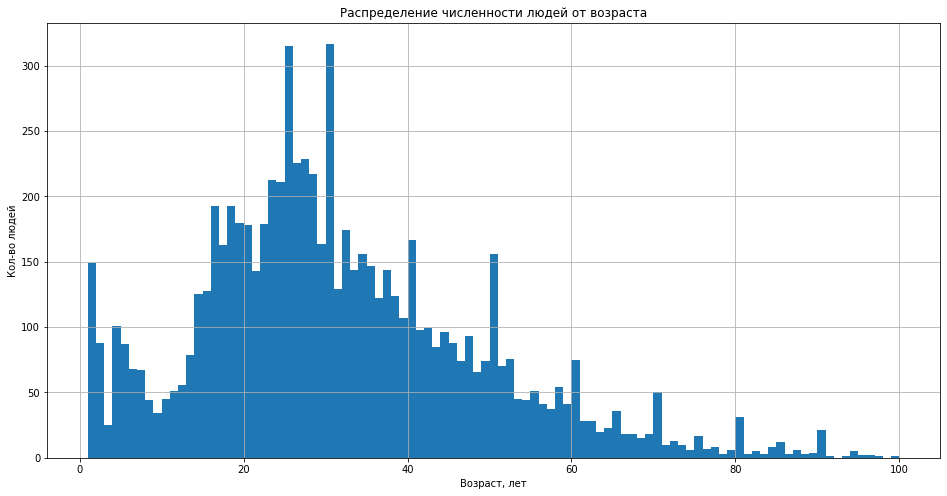

In [6]:
df['real_age'].plot(kind='hist', bins=99, figsize=(16, 8), grid=True)
plt.title('Распределение численности людей от возраста')
plt.ylabel('Кол-во людей')
plt.xlabel('Возраст, лет');

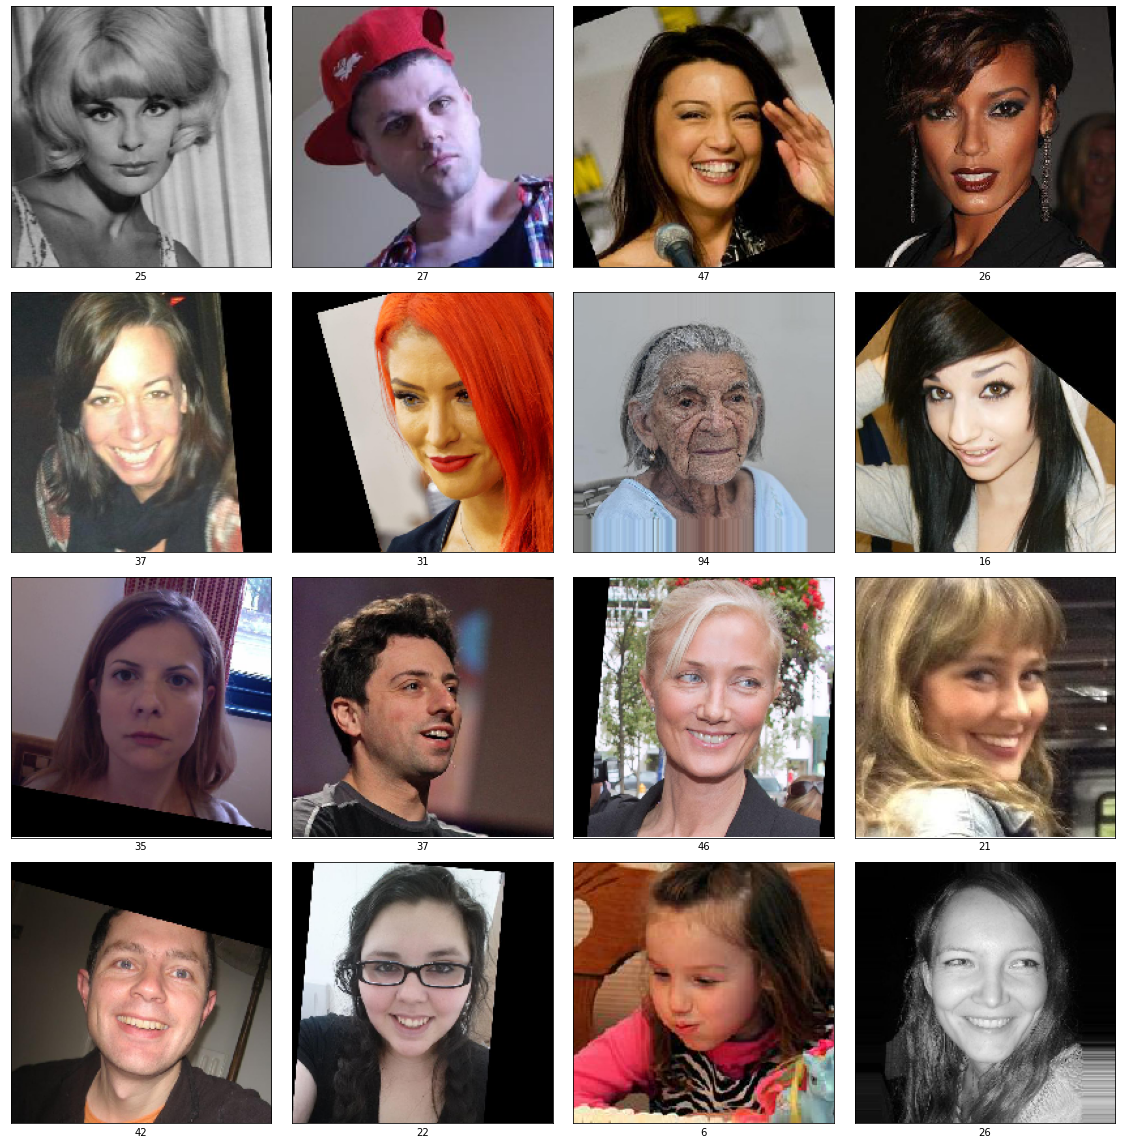

In [7]:
fig = plt.figure(figsize=(16, 16))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i+8])
    plt.xlabel(target[i+8])
    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:**

Анализируемый датасет состоит из 7 591 изображения. Пропущенные значения и дублирующие записи в данных отсутствуют.

Набор данных включает как цветные, так и монохромные фотографии. Изображения характеризуются значительным разнообразием ракурсов.

Распределение объектов по возрастным группам неравномерное. Наибольшая концентрация наблюдается в диапазоне 15–30 лет с выраженными пиками в 25 и 30 лет. Также отмечается значительное количество изображений младенцев в возрасте до 1 года, что, вероятно, связано с процедурой округления возраста (значения менее года, судя по данным, округлялись в большую сторону; категория "0 лет" отсутствует).

В соответствии с поставленной задачей необходимо будет анализировать покупки и предлагать товары, которые могут заинтересовать покупателей той или иной возрастной группы, а также контролировать добросовестность кассиров при продаже алкоголя. Соответственно, было бы логично исключить из датасета изображения детей младше 7 лет, поскольку данная категория лиц как правило сопровождается взрослыми.

## Обучение модели

```python
def load_train(path):

    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255) #, vertical_flip=True, horizontal_flip=True)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        directory=path + '/final_files',
        dataframe=pd.read_csv(path + '/labels.csv'),
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow

def load_test(path):
    valid_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    valid_datagen_flow = valid_datagen.flow_from_dataframe(
        directory=path + '/final_files',
        dataframe=pd.read_csv(path + '/labels.csv'),
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return valid_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    
    model = Sequential() 
    model.add(backbone) 
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
2025-03-26 11:22:13.894352: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2025-03-26 11:22:13.896570: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2025-03-26 11:22:15.038794: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-03-26 11:22:15.045569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-03-26 11:22:15.045632: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-03-26 11:22:15.045673: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-26 11:22:15.047805: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-03-26 11:22:15.048250: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-03-26 11:22:15.050574: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-03-26 11:22:15.051901: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-03-26 11:22:15.051979: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-03-26 11:22:15.054298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2025-03-26 11:22:15.272413: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2025-03-26 11:22:15.285293: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2025-03-26 11:22:15.286281: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3b5cfb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-03-26 11:22:15.286322: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-03-26 11:22:15.516529: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4e72150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-26 11:22:15.516571: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2025-03-26 11:22:15.518111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-03-26 11:22:15.518177: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-03-26 11:22:15.518205: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-26 11:22:15.518246: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-03-26 11:22:15.518278: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-03-26 11:22:15.518309: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-03-26 11:22:15.518338: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-03-26 11:22:15.518360: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-03-26 11:22:15.521269: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2025-03-26 11:22:15.521332: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-03-26 11:22:16.309518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-03-26 11:22:16.309563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2025-03-26 11:22:16.309573: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2025-03-26 11:22:16.312136: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-03-26 11:22:16.312189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
  229376/94765736 [..............................] - ETA: 20s
 1196032/94765736 [..............................] - ETA: 7s 
 6586368/94765736 [=>............................] - ETA: 2s
13459456/94765736 [===>..........................] - ETA: 1s
19529728/94765736 [=====>........................] - ETA: 0s
25640960/94765736 [=======>......................] - ETA: 0s
32448512/94765736 [=========>....................] - ETA: 0s
39534592/94765736 [===========>..................] - ETA: 0s
47030272/94765736 [=============>................] - ETA: 0s
53657600/94765736 [===============>..............] - ETA: 0s
60702720/94765736 [==================>...........] - ETA: 0s
67952640/94765736 [====================>.........] - ETA: 0s
75587584/94765736 [======================>.......] - ETA: 0s
83361792/94765736 [=========================>....] - ETA: 0s
90529792/94765736 [===========================>..] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2025-03-26 11:22:35.346911: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-26 11:22:35.989110: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 68s - loss: 192.3539 - mae: 10.3186 - val_loss: 530.4661 - val_mae: 17.9639
Epoch 2/10
178/178 - 46s - loss: 94.7740 - mae: 7.4448 - val_loss: 497.9806 - val_mae: 17.2221
Epoch 3/10
178/178 - 54s - loss: 57.8593 - mae: 5.8103 - val_loss: 393.5872 - val_mae: 14.8061
Epoch 4/10
178/178 - 57s - loss: 36.5663 - mae: 4.6727 - val_loss: 198.7925 - val_mae: 10.3498
Epoch 5/10
178/178 - 61s - loss: 26.5902 - mae: 3.9374 - val_loss: 104.1367 - val_mae: 7.8381
Epoch 6/10
178/178 - 68s - loss: 18.1206 - mae: 3.2937 - val_loss: 82.6324 - val_mae: 6.7928
Epoch 7/10
178/178 - 65s - loss: 13.8023 - mae: 2.8824 - val_loss: 73.5700 - val_mae: 6.5419
Epoch 8/10
178/178 - 49s - loss: 10.8542 - mae: 2.5220 - val_loss: 74.2316 - val_mae: 6.5923
Epoch 9/10
178/178 - 48s - loss: 9.8916 - mae: 2.4287 - val_loss: 71.2976 - val_mae: 6.4283
Epoch 10/10
178/178 - 51s - loss: 8.9908 - mae: 2.2695 - val_loss: 78.0144 - val_mae: 6.8814
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 78.0144 - mae: 6.8814
Test MAE: 6.8814
```

## Анализ обученной модели

**Технические параметры обучения**
- **Фреймворк:** TensorFlow с бэкендом Keras  
- **Архитектура модели:** ResNet50 (предобученные веса)  

**Данные**
- **Обучающая выборка:** 5,694 изображения  
- **Валидационная выборка:** 1,897 изображений  
- **Формат данных:** RGB и grayscale изображения с различными ракурсами и условиями освещения

**Метрики обучения**
Обучение проводилось в течение 10 эпох с мониторингом следующих метрик:
- Loss (MSE): Среднеквадратичная ошибка
- MAE (Mean Absolute Error): Средняя абсолютная ошибка (ключевая метрика для регрессии возраста)


| Эпоха | Train Loss | Train MAE | Val Loss | Val MAE  |
|-------|-----------|----------|----------|----------|
| 1     | 192.35    | 10.32    | 530.47   | 17.96    |
| 2     | 94.77     | 7.44     | 497.98   | 17.22    |
| 3     | 57.86     | 5.81     | 393.59   | 14.81    |
| 4     | 36.57     | 4.67     | 198.79   | 10.35    |
| 5     | 26.59     | 3.94     | 104.14   | 7.84     |
| 6     | 18.12     | 3.29     | 82.63    | 6.79     |
| 7     | 13.80     | 2.88     | 73.57    | 6.54     |
| 8     | 10.85     | 2.52     | 74.23    | 6.59     |
| 9     | 9.89      | 2.43     | 71.30    | 6.43     |
| 10    | 8.99      | 2.27     | 78.01    | 6.88     |

- Train MAE снизился с 10.32 до 2.27, что свидетельствует о хорошей сходимости модели.
- Val MAE достиг 6.88, что указывает на приемлемую обобщающую способность.

**Результаты тестирования**

Test MAE = 6.8814

Cледовательно, модель в среднем ошибается на ~6.88 лет при предсказании возраста.

Переобучения не наблюдается (val loss не растет).

MAE на валидации и тесте близки, что говорит об адекватной генерализации.

**Заключение:**
Модель достигла удовлетворительной точности (MAE ≈ 6.88 лет) и готова к применению в задачах оценки возраста. Для повышения точности рекомендуется дообучение на более сбалансированном датасете.